Generating original data...
Initializing DDPM schedule and model...

Training diffusion model...
Epoch 200/1000, Loss: 0.511901
Epoch 400/1000, Loss: 0.546943
Epoch 600/1000, Loss: 0.556921
Epoch 800/1000, Loss: 0.505349
Epoch 1000/1000, Loss: 0.523902

Generating samples via DDPM sampling...

Visualization saved as 'ddpm_diffusion_3d.png'
Complete!


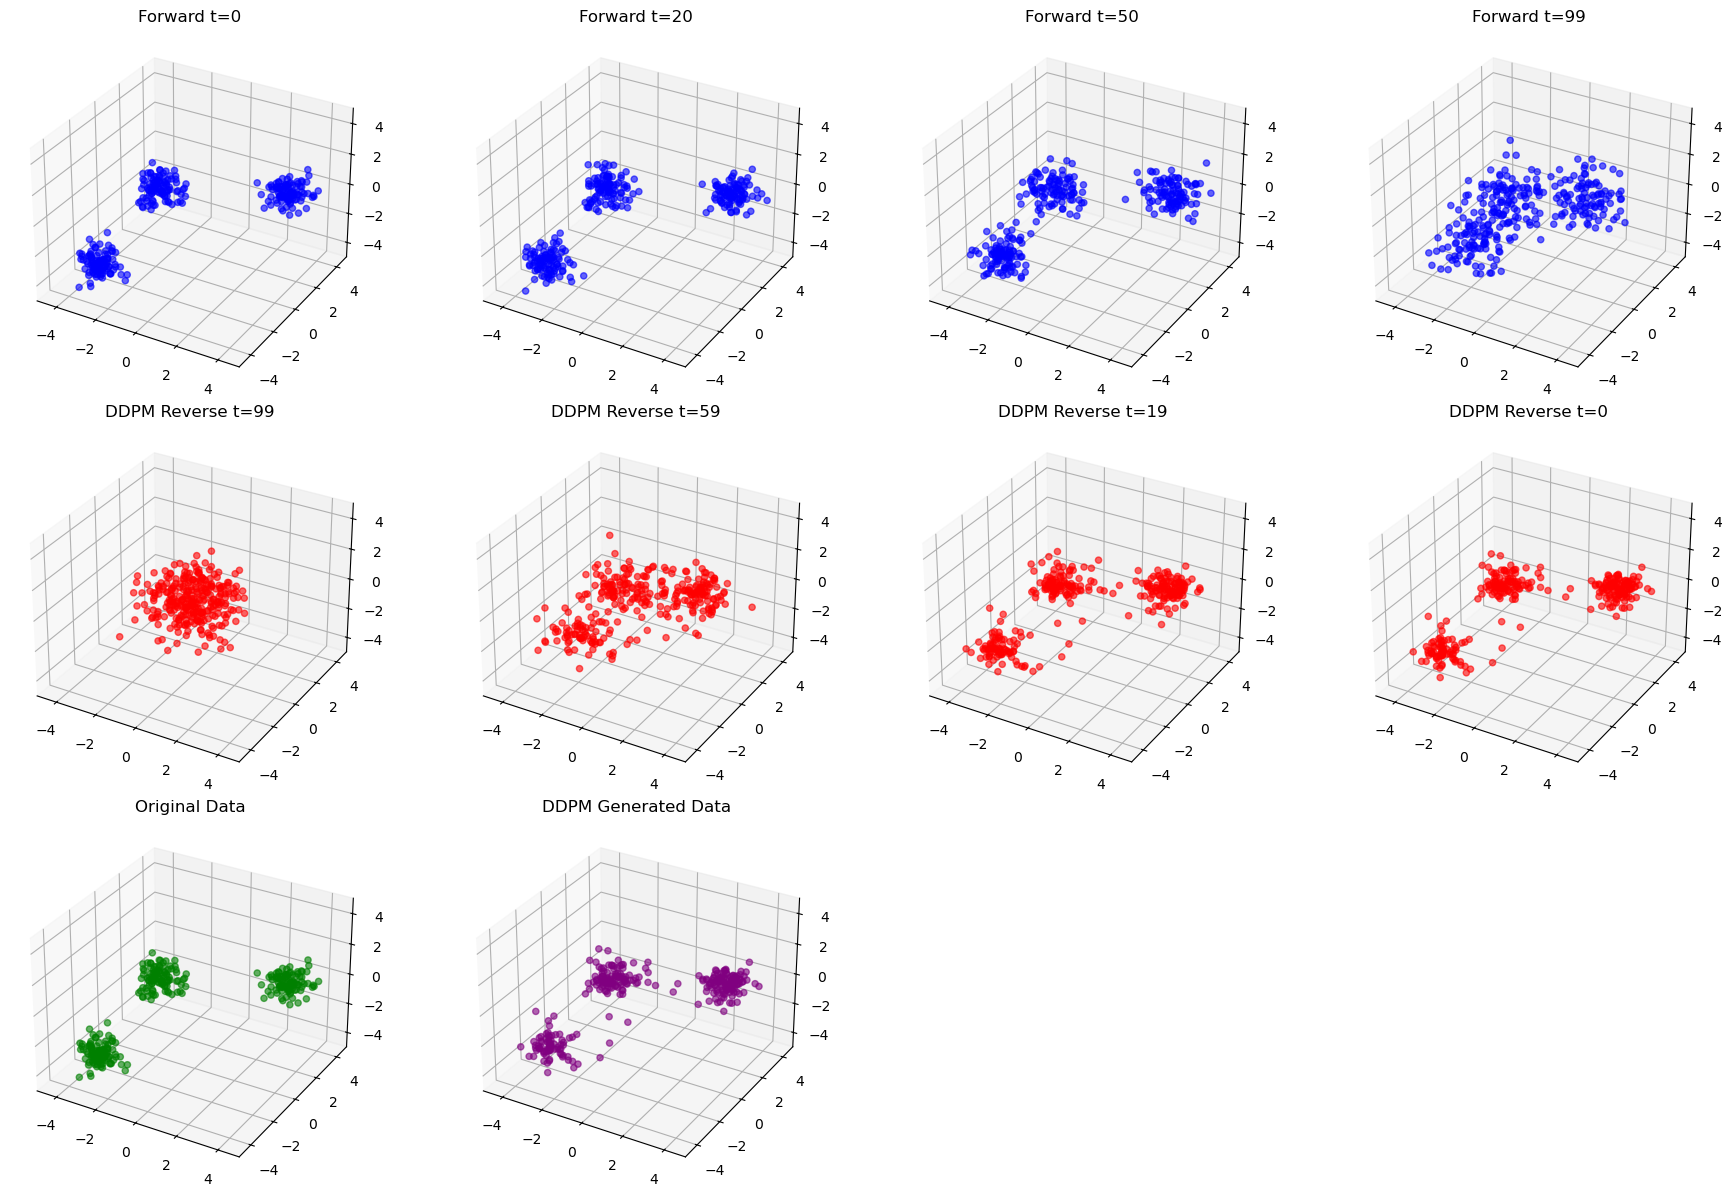

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Generate 3D clustered data (3 separate clusters)
def generate_clustered_data(n_samples=300):
    """Generate 3 clusters in 3D space"""
    samples_per_cluster = n_samples // 3
    
    # Cluster 1: centered at (-3, -3, -3)
    cluster1 = np.random.randn(samples_per_cluster, 3) * 0.5 + np.array([-3, -3, -3])
    
    # Cluster 2: centered at (3, 3, 0)
    cluster2 = np.random.randn(samples_per_cluster, 3) * 0.5 + np.array([3, 3, 0])
    
    # Cluster 3: centered at (0, -3, 3)
    cluster3 = np.random.randn(samples_per_cluster, 3) * 0.5 + np.array([0, -3, 3])
    
    data = np.vstack([cluster1, cluster2, cluster3])
    return torch.FloatTensor(data)

# Simple MLP for denoising
class DenoisingNet(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=128, time_embed_dim=32):
        super().__init__()
        self.time_embed = nn.Sequential(
            nn.Linear(1, time_embed_dim),
            nn.ReLU(),
            nn.Linear(time_embed_dim, time_embed_dim)
        )
        
        self.net = nn.Sequential(
            nn.Linear(input_dim + time_embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    
    def forward(self, x, t):
        # Embed time
        t_embed = self.time_embed(t.view(-1, 1))
        # Concatenate x and time embedding
        x_t = torch.cat([x, t_embed], dim=1)
        return self.net(x_t)

# DDPM diffusion schedule
class DDPMSchedule:
    def __init__(self, timesteps=100, beta_start=0.0001, beta_end=0.02):
        self.timesteps = timesteps
        
        # Linear schedule
        self.betas = torch.linspace(beta_start, beta_end, timesteps)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = torch.cat([torch.tensor([1.0]), self.alphas_cumprod[:-1]])
        
        # Calculations for diffusion q(x_t | x_{t-1})
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        
        # Calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )

# Forward diffusion: q(x_t | x_0)
def forward_diffusion(schedule, x0, t, noise=None):
    """
    Sample from q(x_t | x_0)
    x_t = sqrt(alpha_bar_t) * x0 + sqrt(1 - alpha_bar_t) * noise
    """
    if noise is None:
        noise = torch.randn_like(x0)
    
    sqrt_alpha_bar = schedule.sqrt_alphas_cumprod[t].view(-1, 1)
    sqrt_one_minus_alpha_bar = schedule.sqrt_one_minus_alphas_cumprod[t].view(-1, 1)
    
    return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise, noise

# Training loop
def train_diffusion_model(data, model, schedule, n_epochs=1000):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    for epoch in range(n_epochs):
        # Sample random timesteps
        t = torch.randint(0, schedule.timesteps, (data.shape[0],))
        
        # Forward diffusion: add noise
        x_noisy, noise = forward_diffusion(schedule, data, t)
        
        # Predict noise using the model
        t_normalized = t.float() / schedule.timesteps
        predicted_noise = model(x_noisy, t_normalized)
        
        # MSE loss between predicted and actual noise
        loss = nn.MSELoss()(predicted_noise, noise)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 200 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.6f}")
    
    return model

# DDPM reverse diffusion sampling: p(x_{t-1} | x_t)
@torch.no_grad()
def ddpm_sample(model, schedule, n_samples=300):
    """
    DDPM sampling algorithm from the paper:
    Sample x_{t-1} ~ p(x_{t-1} | x_t) using the learned model
    """
    # Start from pure Gaussian noise x_T ~ N(0, I)
    x = torch.randn(n_samples, 3)
    
    samples_over_time = [x.numpy()]
    
    # Reverse process: t = T, T-1, ..., 1
    for t_idx in reversed(range(schedule.timesteps)):
        t = torch.full((n_samples,), t_idx, dtype=torch.long)
        t_normalized = t.float() / schedule.timesteps
        
        # Predict noise epsilon_theta(x_t, t)
        predicted_noise = model(x, t_normalized)
        
        # Get schedule parameters
        alpha_t = schedule.alphas[t_idx]
        alpha_bar_t = schedule.alphas_cumprod[t_idx]
        beta_t = schedule.betas[t_idx]
        
        # Compute mean of p(x_{t-1} | x_t)
        # mu = (1/sqrt(alpha_t)) * (x_t - (beta_t/sqrt(1-alpha_bar_t)) * epsilon_theta)
        sqrt_alpha_t = torch.sqrt(alpha_t)
        sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t)
        
        mean = (1 / sqrt_alpha_t) * (x - (beta_t / sqrt_one_minus_alpha_bar_t) * predicted_noise)
        
        # Sample x_{t-1} ~ N(mean, variance * I)
        if t_idx > 0:
            noise = torch.randn_like(x)
            variance = schedule.posterior_variance[t_idx]
            x = mean + torch.sqrt(variance) * noise
        else:
            # No noise at t=0
            x = mean
        
        # Save samples at specific timesteps for visualization
        if t_idx % 20 == 0:
            samples_over_time.append(x.numpy())
    
    return samples_over_time

# Main execution
print("Generating original data...")
original_data = generate_clustered_data(300)

print("Initializing DDPM schedule and model...")
schedule = DDPMSchedule(timesteps=100)
model = DenoisingNet()

print("\nTraining diffusion model...")
model = train_diffusion_model(original_data, model, schedule, n_epochs=1000)

print("\nGenerating samples via DDPM sampling...")
generated_samples = ddpm_sample(model, schedule, n_samples=300)

# Visualization
fig = plt.figure(figsize=(18, 12))

# Row 1: Forward diffusion process
forward_steps = [0, 20, 50, 99]
for idx, step in enumerate(forward_steps):
    ax = fig.add_subplot(3, 4, idx + 1, projection='3d')
    t = torch.full((300,), step, dtype=torch.long)
    noisy_data, _ = forward_diffusion(schedule, original_data, t)
    noisy_np = noisy_data.numpy()
    ax.scatter(noisy_np[:, 0], noisy_np[:, 1], noisy_np[:, 2], 
               c='blue', alpha=0.6, s=20)
    ax.set_title(f'Forward t={step}')
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])
    ax.set_zlim([-5, 5])

# Row 2: DDPM reverse sampling process
reverse_indices = [0, 2, 4, -1]
for idx, rev_idx in enumerate(reverse_indices):
    ax = fig.add_subplot(3, 4, idx + 5, projection='3d')
    sample = generated_samples[rev_idx]
    ax.scatter(sample[:, 0], sample[:, 1], sample[:, 2], 
               c='red', alpha=0.6, s=20)
    timestep = 99 - (rev_idx * 20) if rev_idx != -1 else 0
    ax.set_title(f'DDPM Reverse t={timestep}')
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])
    ax.set_zlim([-5, 5])

# Row 3: Comparison
ax = fig.add_subplot(3, 4, 9, projection='3d')
orig_np = original_data.numpy()
ax.scatter(orig_np[:, 0], orig_np[:, 1], orig_np[:, 2], 
           c='green', alpha=0.6, s=20)
ax.set_title('Original Data')
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
ax.set_zlim([-5, 5])

ax = fig.add_subplot(3, 4, 10, projection='3d')
final_generated = generated_samples[-1]
ax.scatter(final_generated[:, 0], final_generated[:, 1], final_generated[:, 2], 
           c='purple', alpha=0.6, s=20)
ax.set_title('DDPM Generated Data')
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
ax.set_zlim([-5, 5])

plt.tight_layout()
plt.savefig('ddpm_diffusion_3d.png', dpi=150, bbox_inches='tight')
print("\nVisualization saved as 'ddpm_diffusion_3d.png'")
print("Complete!")

plt.show()